In [26]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set()
%config InlineBackend.figure_format = 'retina'


import librosa
import optuna

In [27]:
train_data = pd.read_csv('C:/Users/pench/OneDrive/Desktop/birdclef-2024/train_metadata.csv')
train_data.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg


In [28]:
train_data.shape

(24459, 12)

In [29]:
train_data.columns

Index(['primary_label', 'secondary_labels', 'type', 'latitude', 'longitude',
       'scientific_name', 'common_name', 'author', 'license', 'rating', 'url',
       'filename'],
      dtype='object')

In [31]:
print("Number of unique names of birds: ", train_data.primary_label.nunique())

Number of unique names of birds:  182


In [32]:
value_counts_bird = train_data.primary_label.value_counts().reset_index()
print("Value Counts of birds in train data:")
value_counts_bird

Value Counts of birds in train data:


,primary_label,count
0,zitcis1,500
1,lirplo,500
2,litgre1,500
3,comgre,500
4,comkin1,500
...,...,...
177,blaeag1,6
178,wynlau1,6
179,niwpig1,5
180,asiope1,5


In [33]:
train_data.rating.describe()['mean']

3.8434931926898073

In [34]:
min_samples_per_species = 500

sampled_data = train_data.groupby('primary_label', group_keys=False).apply(lambda x: x.sample(min(len(x), min_samples_per_species), random_state=42))

sampled_data = sampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

C:\Users\pench\AppData\Local\Temp\ipykernel_3320\2553835596.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = train_data.groupby('primary_label', group_keys=False).apply(lambda x: x.sample(min(len(x), min_samples_per_species), random_state=21))


In [35]:
sampled_data.shape

(24459, 12)

In [36]:
SR = 32000 # 100
DURATION = 15
N_FFT = 2048 # 100

In [37]:
%%time
sound_data = []
sound_rate_data = []
for file_name in sampled_data.filename:
    file_path = os.path.join('C:/Users/pench/OneDrive/Desktop/birdclef-2024/train_audio/', file_name)    
    sound, sr = librosa.load(file_path, sr=SR, duration=DURATION)
#     rms_file = librosa.feature.rms(y=sound, hop_length=30)
    mfcc = librosa.feature.mfcc(y=sound, sr=sr, n_fft=N_FFT)
    mfcc_sound = mfcc.mean(axis=1)
    sound_data.append(mfcc_sound)

CPU times: total: 5min 9s
Wall time: 12min


In [38]:
sound_data[:5]

[array([-4.7564365e+02,  1.1057095e+02, -8.7197876e+01,  2.2136614e+01,
         7.7044568e+00, -4.4703732e+00,  1.4085218e+01, -5.1760864e+00,
         4.6983752e+00,  3.4395556e+00,  7.5066133e+00, -5.5040014e-01,
        -5.8760729e+00,  1.3056787e+01,  1.4258533e+00, -4.2661915e+00,
         1.6279253e-01, -1.4204188e-01,  2.7269747e+00, -4.1471219e+00],
       dtype=float32),
 array([-314.07816  ,   11.478308 , -106.21097  ,   56.371563 ,
         -72.69879  ,   25.085804 ,  -52.416897 ,  -34.94647  ,
           5.272666 ,  -42.437393 ,  -13.599385 ,  -11.889186 ,
          -8.314347 ,  -18.595076 ,    1.6064831,  -10.951144 ,
           2.077883 ,   -4.207936 ,   -5.3873425,    7.13845  ],
       dtype=float32),
 array([-310.63657  ,   -6.4178843, -120.93245  ,  -30.969913 ,
         -29.479961 ,  -20.768337 ,  -27.510803 ,  -27.789022 ,
         -40.255383 ,  -26.027424 ,  -23.309427 ,   -6.788182 ,
           1.7667698,   15.605968 ,    9.617308 ,   18.386404 ,
           1.724

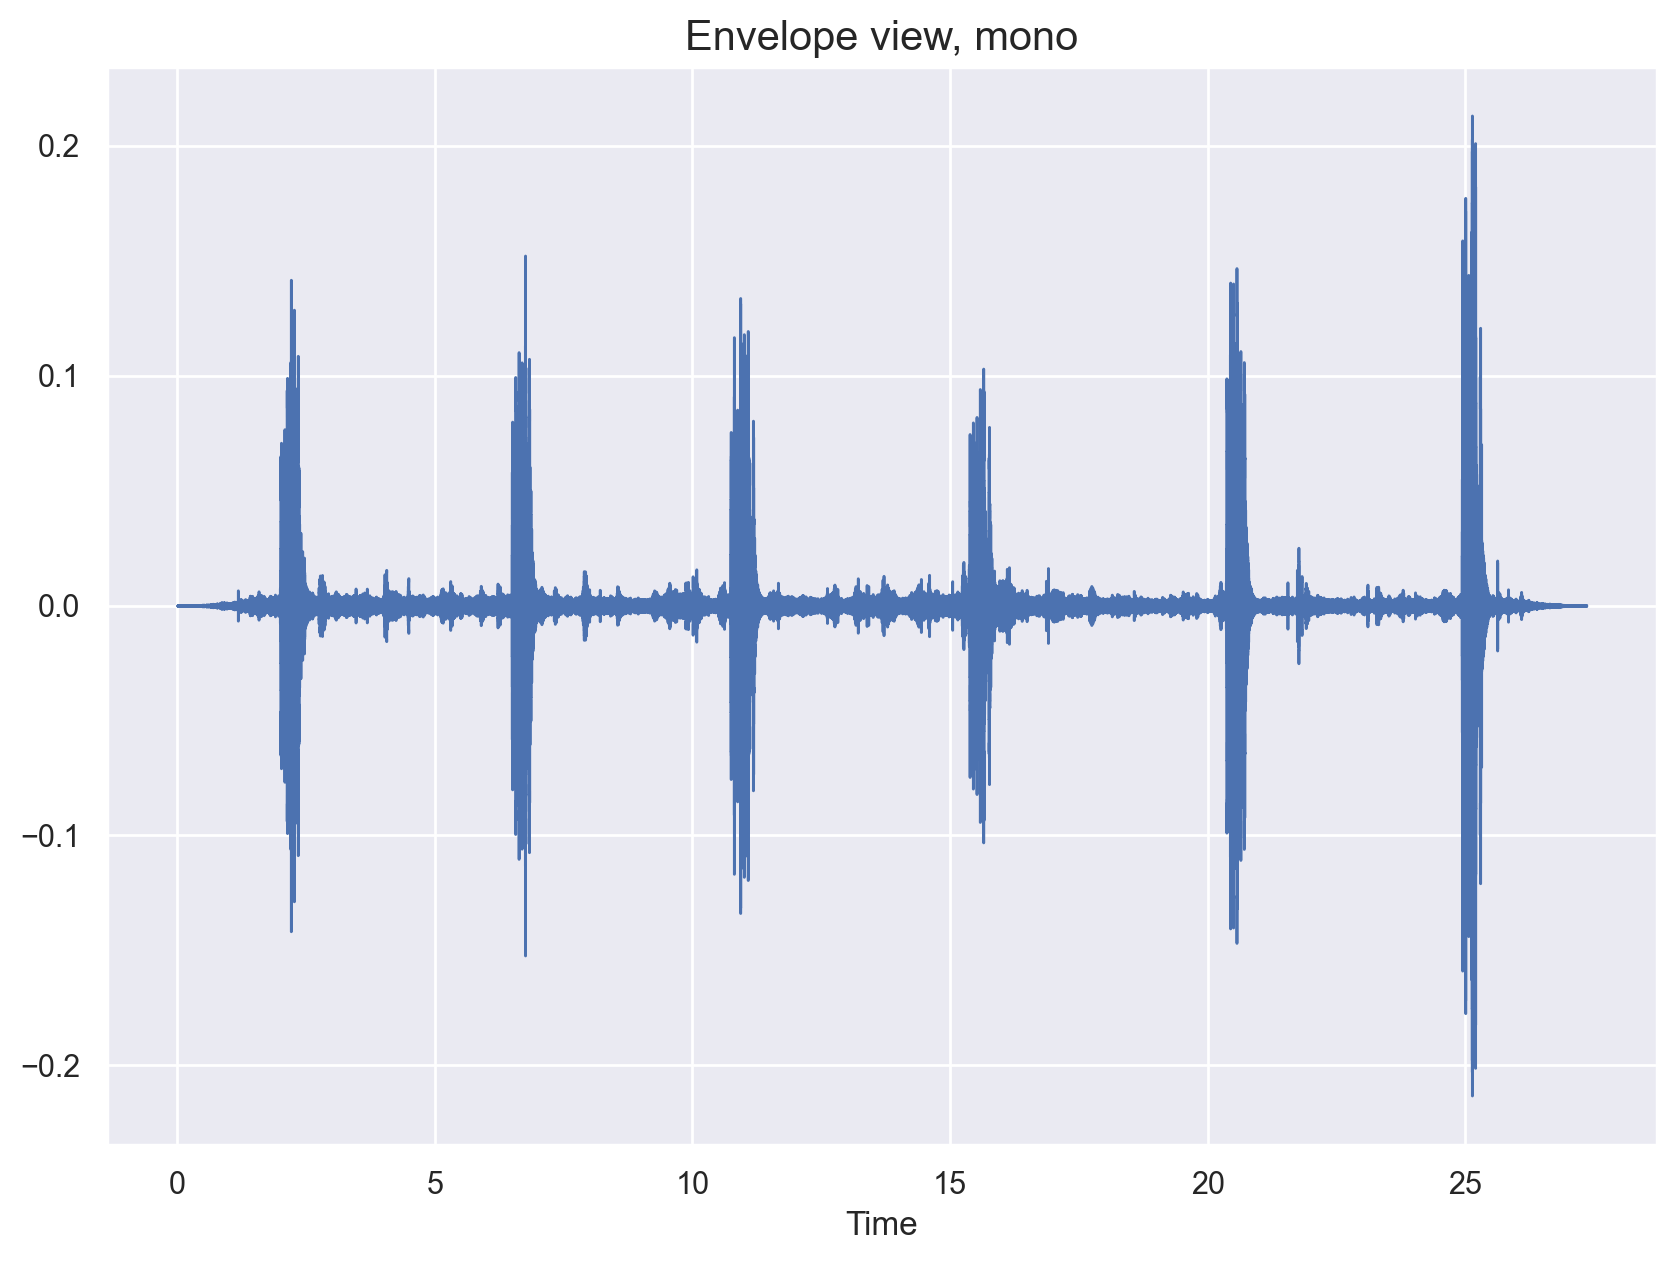

In [65]:
sound, sr = librosa.load('C:/Users/pench/OneDrive/Desktop/birdclef-2024/train_audio/asbfly/XC134896.ogg')

fig, axes = plt.subplots(figsize=(10, 7))

librosa.display.waveshow(sound, sr=sr)
axes.set_title("Envelope view, mono", fontsize=15)

plt.show()

In [40]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(sampled_data.primary_label)

In [41]:
sound_data[0].shape[0]

20

In [42]:
sound_data[0]

array([-4.7564365e+02,  1.1057095e+02, -8.7197876e+01,  2.2136614e+01,
        7.7044568e+00, -4.4703732e+00,  1.4085218e+01, -5.1760864e+00,
        4.6983752e+00,  3.4395556e+00,  7.5066133e+00, -5.5040014e-01,
       -5.8760729e+00,  1.3056787e+01,  1.4258533e+00, -4.2661915e+00,
        1.6279253e-01, -1.4204188e-01,  2.7269747e+00, -4.1471219e+00],
      dtype=float32)

In [43]:
min_shape = 100000000000
for audio in sound_data:
    if audio.shape[0] < min_shape:
        min_shape = audio.shape[0]
print(min_shape)

20


In [44]:
equal_data = [librosa.util.fix_length(sound, size=20) for sound in sound_data]

In [45]:
min_shape = 100000000000
for audio in equal_data:
    if audio.shape[0] < min_shape:
        min_shape = audio.shape[0]
print(min_shape)

20


In [46]:
filtered_sound_data = np.array(sound_data)

In [47]:
filtered_sound_data.shape

(24459, 20)

In [48]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy={class_label: 500 for class_label in range(182)}, random_state=42)
X_ros, y_ros = ros.fit_resample(filtered_sound_data, y)

In [49]:
X_ros.shape

(91000, 20)

In [50]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score


class Searcher:
    RANDOM_STATE = 42

    def __init__(self, features, label):
        #         label = self.columns_transformer().fit_transform(label)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(features,
                                                                                label,
                                                                                test_size=0.2,
                                                                                random_state=self.RANDOM_STATE)

    def searcher(self, estimator, param_grid, random: bool = False):
        searcher = self.random_search(estimator, param_grid) if random else self.grid_search(estimator, param_grid)
        self.print_results_searching(searcher)

        return searcher

    def grid_search(self, estimator, param_grid):
        searching = GridSearchCV(self.make_model(estimator),
                                 param_grid=param_grid,
                                 scoring=self.make_f1_scorer(),
                                 cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=self.RANDOM_STATE),
                                 n_jobs=-1,
                                 verbose=1)
        return searching.fit(self.X_train, self.y_train)

    def random_search(self, estimator, param_distributions):
        searching = RandomizedSearchCV(self.make_model(estimator),
                                       param_distributions=param_distributions,
                                       n_iter=10,
                                       scoring=self.make_f1_scorer(),
                                       cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=self.RANDOM_STATE),
                                       n_jobs=-1,
                                       verbose=1)
        return searching.fit(self.X_train, self.y_train)

    @staticmethod
    def print_results_searching(searcher):
        best_params = searcher.best_params_
        best_score = searcher.best_score_
        print("-" * 50)
        print("***RESULTS SEARCHING***")
        print(f"Best estimator's params: {best_params}")
        print(f"Best searching score: {best_score}")
        print("-" * 50)

    @staticmethod
    def make_model(estimator):
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('estimator', estimator)
        ])

        return model


    @staticmethod
    def make_f1_scorer():
        return make_scorer(f1_score, average='macro')


class Model(Searcher):
    def __init__(self, features, label):
        super().__init__(features, label)

    def __call__(self, estimator, param_grid, random: bool = False):
        searcher = self.searcher(estimator, param_grid, random)
        best_params = self.get_searching_params(searcher.best_params_)

        estimator.set_params(**best_params).fit(self.X_train, self.y_train)
        self.print_results(estimator)
        
        return estimator

    def print_results(self, model):
        y_pred = model.predict(self.X_test)

        print("***RESULTS MODEL***")
        print(f"Accuracy train score: {model.score(self.X_train, self.y_train)}")
        print(f"Accuracy test score: {model.score(self.X_test, self.y_test)}")
        print(
            f"Cross validation score: {cross_val_score(model, self.X_test, self.y_test, scoring=self.make_f1_scorer(), cv=StratifiedKFold(shuffle=True, random_state=self.RANDOM_STATE))}")
        print(f"Precision score: {precision_score(self.y_test, y_pred, average='macro')}")
        print(f"Recall score: {recall_score(self.y_test, y_pred, average='macro')}")
        print(f"F1 score: {f1_score(self.y_test, y_pred, average='macro')}")
        print("-" * 50)

    @staticmethod
    def get_searching_params(params):
        return {param_name.split('estimator__')[1]: param for param_name, param in params.items()}

In [51]:
model = Model(X_ros, y_ros)

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [53]:
%%time
knn_params = {
    'estimator__n_neighbors': [1, 2, 3, 4, 5],
    'estimator__leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'estimator__weights': ['uniform', 'distance'],
}

knn_model = model(KNeighborsClassifier(),  knn_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------
***RESULTS SEARCHING***
Best estimator's params: {'estimator__leaf_size': 1, 'estimator__n_neighbors': 1, 'estimator__weights': 'uniform'}
Best searching score: 0.8468811372946687
--------------------------------------------------
***RESULTS MODEL***
Accuracy train score: 1.0
Accuracy test score: 0.8611538461538462
Cross validation score: [0.64105789 0.63668257 0.63665602 0.63947249 0.63973148]
Precision score: 0.836453160256406
Recall score: 0.8591828289271374
F1 score: 0.8460765389640917
--------------------------------------------------
CPU times: total: 55.8 s
Wall time: 4min 48s


In [60]:
# Process the test data
sound_test_data = []
sound_test_rate_data = []
idx = []
for sound_name in os.listdir('C:/Users/pench/OneDrive/Desktop/birdclef-2024/unlabeled_soundscapes'):
    sound, sr = librosa.load(os.path.join('C:/Users/pench/OneDrive/Desktop/birdclef-2024/unlabeled_soundscapes', sound_name), sr=32000, duration=20)
    mfcc = librosa.feature.mfcc(y=sound, sr=sr)
    mfcc_sound = mfcc.mean(axis=1)
    sound_test_data.append(mfcc_sound)
    sound_test_rate_data.append(sr)
    idx.append(sound_name)

# Get predictions
test_pred = knn_model.predict_proba(sound_test_data)

# Get the predicted class indices
predicted_class_indices = np.argmax(test_pred, axis=1)

# Map the indices to the bird species names
predicted_species = le.inverse_transform(predicted_class_indices)

# Create a DataFrame with the filenames and their predicted species
submission = pd.DataFrame({
    'filename': idx,
    'predicted_species': predicted_species
})

# Print the DataFrame
print(submission.head())

# Optionally, save to CSV
submission.to_csv('predicted_species.csv', index=False)

         filename predicted_species
0  1000170626.ogg            barswa
1  1000308629.ogg           brwjac1
2  1000389428.ogg           grbeat1
3  1000424265.ogg            bcnher
4  1000450112.ogg            comgre


In [67]:
import pickle
filename='trained_model.sav'
pickle.dump(knn_model, open(filename , 'wb'))

In [68]:
#loading the saved model
loaded_model=pickle.load(open('trained_model.sav','rb'))

In [69]:
# Get predictions
test_pred = loaded_model.predict_proba(sound_test_data)

# Get the predicted class indices
predicted_class_indices = np.argmax(test_pred, axis=1)

# Map the indices to the bird species names
predicted_species = le.inverse_transform(predicted_class_indices)

# Create a DataFrame with the filenames and their predicted species
submission = pd.DataFrame({
    'filename': idx,
    'predicted_species': predicted_species
})

# Print the DataFrame
print(submission.head())


         filename predicted_species
0  1000170626.ogg            barswa
1  1000308629.ogg           brwjac1
2  1000389428.ogg           grbeat1
3  1000424265.ogg            bcnher
4  1000450112.ogg            comgre
